<h2> 3.6 Featurizing text data with tfidf weighted word-vectors </h2>

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import numpy as np
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import sys
import os 
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm

# exctract word2vec vectors
# https://github.com/explosion/spaCy/issues/1721
# http://landinghub.visualstudio.com/visual-cpp-build-tools
import spacy

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

In [3]:
# avoid decoding problems
df = pd.read_csv("train.csv")
 
# encode questions to unicode
# https://stackoverflow.com/a/6812069
# ----------------- python 2 ---------------------
# df['question1'] = df['question1'].apply(lambda x: unicode(str(x),"utf-8"))
# df['question2'] = df['question2'].apply(lambda x: unicode(str(x),"utf-8"))
# ----------------- python 3 ---------------------
df['question1'] = df['question1'].apply(lambda x: str(x))
df['question2'] = df['question2'].apply(lambda x: str(x))

In [4]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [5]:
#prepro_features_train.csv (Simple Preprocessing Feartures)
#nlp_features_train.csv (NLP Features)
if os.path.isfile('nlp_features_train.csv'):
    dfnlp = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
else:
    print("download nlp_features_train.csv from drive or run previous notebook")

if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    dfppro = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    print("download df_fe_without_preprocessing_train.csv from drive or run previous notebook")

In [6]:
df.head(3)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0


In [7]:
dfnlp = dfnlp.drop(["question1","question2"],axis=1)
dfnlp.head(3)

,id,qid1,qid2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,5,6,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,12.0,66,66,54,54,0.166667


In [8]:
dfppro = dfppro.drop(["question1","question2"],axis=1)
dfppro.head(3)

,id,qid1,qid2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0


In [9]:
df_merged = dfnlp.merge(dfppro, on="id")

In [10]:
df_main = df.merge(df_merged, on="id")

In [11]:
df_main.head(3)

,id,qid1,qid2,question1,question2,is_duplicate,qid1_x,qid2_x,is_duplicate_x,cwc_min,...,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,2,0,0.999980,...,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,3,4,0,0.799984,...,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,5,6,0,0.399992,...,1,73,59,14,10,4.0,24.0,0.166667,2,0


In [12]:
df_final = df_main.sample(100000)
df_final.shape

(100000, 38)

In [13]:
# merge texts

#questions = list(df1['question1']) + list(df1['question2'])
X = df_final.drop("is_duplicate",axis=1)
Y = df_final["is_duplicate"]
print(X.shape)
print(type(X))
print(Y.shape)
print(type(Y))

from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.3,random_state=12,shuffle=True)
#X_train,X_cv,Y_train,Y_cv=train_test_split(X,Y,test_size=0.2,random_state=12,shuffle=True)
print('='*100)
print("After splitting")
print(X_train.shape,Y_train.shape)
#print(X_cv.shape,Y_cv.shape)
print(X_test.shape,Y_test.shape)

(100000, 37)
<class 'pandas.core.frame.DataFrame'>
(100000,)
<class 'pandas.core.series.Series'>
After splitting
(70000, 37) (70000,)
(30000, 37) (30000,)


In [14]:
questions1_train = np.array(X_train['question1'].astype("unicode")) 
questions2_train = np.array(X_train['question2'].astype("unicode"))

questions1_test = np.array(X_test['question1'].astype("unicode")) 
questions2_test = np.array(X_test['question2'].astype("unicode"))

In [15]:
questions_train = questions1_train + questions2_train

In [16]:
questions_test = questions1_test + questions2_test

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

tfidf = TfidfVectorizer(lowercase=False,min_df=500, max_features=5000)
X_train_tfidf = tfidf.fit_transform(np.array(X_train['question1'].astype("unicode")) + np.array(X_train['question2'].astype("unicode")))
X_test_tfidf = tfidf.transform(np.array(X_test['question1'].astype("unicode")) + np.array(X_test['question2'].astype("unicode")))

# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

In [18]:
X_train = X_train.drop(["question1","question2"],axis=1)
#print(type(X_train))

X_train = X_train.drop(["is_duplicate_x","qid1_x","qid2_x"],axis=1)
#print(type(X_train))

X_train = X_train.drop(["is_duplicate_y","qid1_y","qid2_y"],axis=1)
#print(type(X_train))

#X_train = X_train.drop(["id"],axis=1)
#print(type(X_train))

X_train = X_train.drop(["qid1","qid2"],axis=1)
#print(type(X_train))

In [19]:
X_test = X_test.drop(["question1","question2"],axis=1)
#print(type(X_train))

X_test = X_test.drop(["is_duplicate_x","qid1_x","qid2_x"],axis=1)
#print(type(X_train))

X_test = X_test.drop(["is_duplicate_y","qid1_y","qid2_y"],axis=1)
#print(type(X_train))

#X_test = X_test.drop(["id"],axis=1)
#print(type(X_train))

X_test = X_test.drop(["qid1","qid2"],axis=1)
#print(type(X_train))

In [20]:
import scipy

In [21]:
X_train_idf = scipy.sparse.hstack([X_train.astype(float), X_train_tfidf.astype(float)], format = "csr")

In [22]:
X_test_idf = scipy.sparse.hstack([X_test.astype(float), X_test_tfidf.astype(float)], format = "csr")

- After we find TF-IDF scores, we convert each question to a weighted average of word2vec vectors by these scores.
- here we use a pre-trained GLOVE model which comes free with "Spacy".  https://spacy.io/usage/vectors-similarity
- It is trained on Wikipedia and therefore, it is stronger in terms of word semantics. 

In [23]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = spacy.load('en_core_web_sm')

vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(questions1_train):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
X_train['q1_feats_m'] = list(vecs1)


In [24]:
vecs2 = []
for qu2 in tqdm(questions2_train):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc1), len(doc2[0].vector)])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
X_train['q2_feats_m'] = list(vecs2)

In [25]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = spacy.load('en_core_web_sm')

vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(questions1_test):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
X_test['q1_feats_t'] = list(vecs1)


In [26]:
vecs2 = []
for qu2 in tqdm(questions2_test):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc1), len(doc2[0].vector)])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
X_test['q2_feats_t'] = list(vecs2)

### Finalizing DataFrame (Train)

In [27]:
df3_q1 = pd.DataFrame(X_train.q1_feats_m.values.tolist(), index= X_train.index)

In [28]:
df3_q2 = pd.DataFrame(X_train.q2_feats_m.values.tolist(), index= X_train.index)

In [29]:
df3_q1['id']=X_train['id']
df3_q2['id']=X_train['id']

In [30]:
df_final_train = X_train.merge(df3_q1,on="id")

In [31]:
df_final_train = df_final_train.merge(df3_q2, on="id")

In [32]:
df_final_train = df_final_train.drop(["q1_feats_m","q2_feats_m","id"],axis= 1)

In [33]:
df_final_train.head(3)

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,...,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
0,0.999950,0.666644,0.999975,0.799984,0.999983,0.749991,0.0,1.0,2.0,7.0,...,-2.910008,-4.046771,-7.272167,28.026936,3.827360,19.044288,2.028453,-7.314273,-3.565585,9.330807
1,0.874989,0.874989,0.999980,0.999980,0.923070,0.923070,0.0,1.0,0.0,13.0,...,56.480804,-24.346811,3.303107,49.851028,50.125510,21.113664,19.891602,13.075670,13.607688,-18.577727
2,0.666644,0.499988,0.199996,0.199996,0.374995,0.333330,0.0,0.0,1.0,8.5,...,16.839105,-14.021545,-4.133141,29.829819,2.070338,15.802740,14.680832,10.105310,-14.677738,12.302985


### Finalizing DataFrame (Test)

In [34]:
df4_q1 = pd.DataFrame(X_test.q1_feats_t.values.tolist(), index= X_test.index)

In [35]:
df4_q2 = pd.DataFrame(X_test.q2_feats_t.values.tolist(), index= X_test.index)

In [36]:
df4_q1['id']=X_test['id']
df4_q2['id']=X_test['id']

In [37]:
df_final_test = X_test.merge(df4_q1,on="id")

In [38]:
df_final_test = df_final_test.merge(df4_q2, on="id")

In [39]:
df_final_test = df_final_test.drop(["q1_feats_t","q2_feats_t","id"],axis= 1)

In [40]:
df_final_test.head(3)

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,...,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
0,0.499988,0.249997,0.571420,0.333331,0.545450,0.230768,0.0,1.0,15.0,18.5,...,32.705267,-4.366542,-10.356503,26.469776,-10.572244,21.491007,14.787162,-4.753901,-2.725673,-0.893614
1,0.333328,0.199998,0.199996,0.099999,0.272725,0.130434,0.0,0.0,12.0,17.0,...,10.510744,-3.795767,-6.977510,6.598917,12.864263,40.352769,0.504109,9.255565,-27.041372,-15.159643
2,0.399992,0.249997,0.333322,0.249994,0.299997,0.272725,0.0,1.0,1.0,10.5,...,43.811498,-3.633122,16.050691,8.762669,-11.210980,38.347708,7.157411,-2.878363,0.312637,18.778862


##### Standardizing the data

In [41]:
from sklearn.preprocessing import normalize

df_final_train = normalize(df_final_train)
df_final_test = normalize(df_final_test)

<h1>4. Machine Learning Models </h1>

In [42]:
print("Number of data points in train data :",df_final_train.shape)
print("Number of data points in test data :",df_final_test.shape)

Number of data points in train data : (70000, 218)
Number of data points in test data : (30000, 218)


In [43]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(Y_train)
train_len = len(Y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in train data", "-"*10)
test_distr = Counter(Y_test)
test_len = len(Y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6313571428571428 Class 1:  0.36864285714285716
---------- Distribution of output variable in train data ----------
Class 0:  0.3701333333333333 Class 1:  0.3701333333333333


In [44]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

<h2> 4.4 Building a random model (Finding worst-case log-loss) </h2>

Log loss on Test Data using Random Model 0.8832758549873778


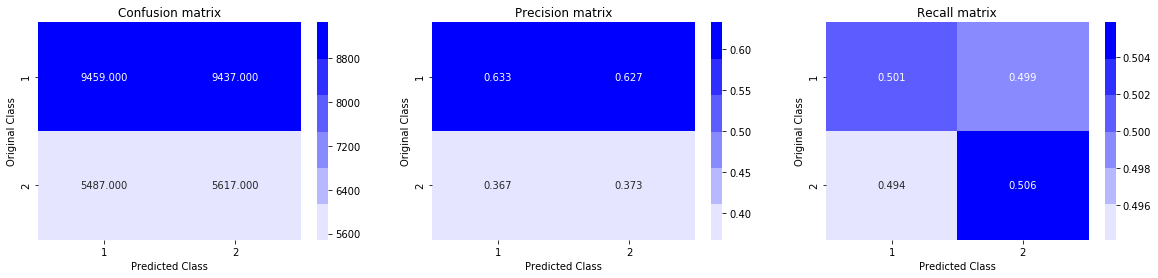

In [45]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(Y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(Y_test, predicted_y)

<h2> 4.4 Logistic Regression with hyperparameter tuning </h2>

For values of alpha =  1e-07 The log loss is: 0.5054425290671226
For values of alpha =  1e-06 The log loss is: 0.49946386008993626
For values of alpha =  1e-05 The log loss is: 0.49377039600644523
For values of alpha =  0.0001 The log loss is: 0.5252172804491245
For values of alpha =  0.001 The log loss is: 0.5663377971848111
For values of alpha =  0.01 The log loss is: 0.5987329044468662
For values of alpha =  0.1 The log loss is: 0.6088930036000808
For values of alpha =  1 The log loss is: 0.6140179355827127
For values of alpha =  10 The log loss is: 0.6215235701466523


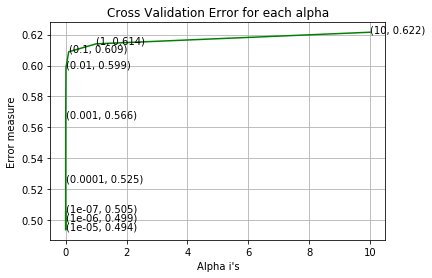

For values of best alpha =  1e-05 The train log loss is: 0.4937056846033866
For values of best alpha =  1e-05 The test log loss is: 0.49377039600644523
Total number of data points : 30000


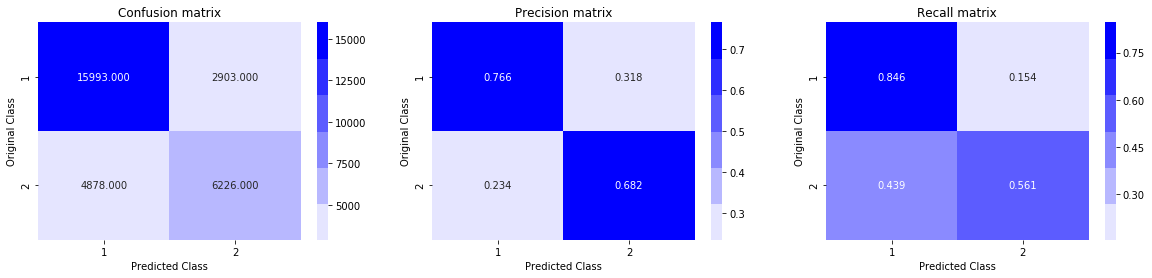

In [46]:
alpha = [10 ** x for x in range(-7, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42,class_weight="balanced")
    clf.fit(df_final_train, Y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(df_final_train, Y_train)
    predict_y = sig_clf.predict_proba(df_final_test)
    log_error_array.append(log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha_LR = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha_LR], penalty='l2', loss='log', random_state=42, class_weight="balanced")
clf.fit(df_final_train, Y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(df_final_train, Y_train)

predict_y = sig_clf.predict_proba(df_final_train)
print('For values of best alpha = ', alpha[best_alpha_LR], "The train log loss is:",log_loss(Y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(df_final_test)
print('For values of best alpha = ', alpha[best_alpha_LR], "The test log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))
log_loss_LR = log_loss(Y_test,predict_y)
predicted_y =np.argmax(predict_y,axis=1)

print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(Y_test, predicted_y)

<h2> 4.5 Linear SVM with hyperparameter tuning </h2>

For values of alpha =  1e-07 The log loss is: 0.4845353883209408
For values of alpha =  1e-06 The log loss is: 0.46940470096532055
For values of alpha =  1e-05 The log loss is: 0.46165431636051774
For values of alpha =  0.0001 The log loss is: 0.49614060178915353
For values of alpha =  0.001 The log loss is: 0.5514125047057531
For values of alpha =  0.01 The log loss is: 0.637116283229448
For values of alpha =  0.1 The log loss is: 0.6590313745273192
For values of alpha =  1 The log loss is: 0.659031374527318
For values of alpha =  10 The log loss is: 0.6590313745273185


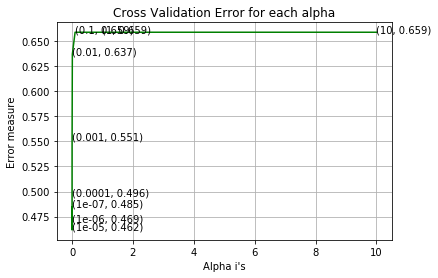

For values of best alpha =  1e-05 The train log loss is: 0.46144235898196817
For values of best alpha =  1e-05 The test log loss is: 0.46165431636051774
Total number of data points : 30000


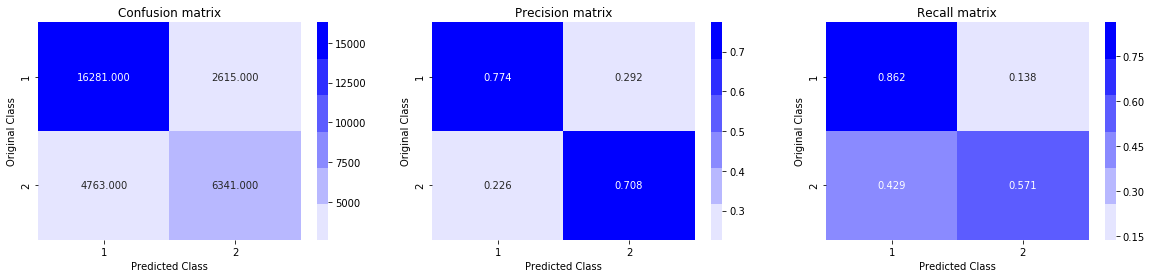

In [47]:
alpha = [10 ** x for x in range(-7, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42,class_weight="balanced")
    clf.fit(df_final_train, Y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(df_final_train, Y_train)
    predict_y = sig_clf.predict_proba(df_final_test)
    log_error_array.append(log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha_svm = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha_svm], penalty='l1', loss='hinge', random_state=42,class_weight="balanced")
clf.fit(df_final_train, Y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(df_final_train, Y_train)

predict_y = sig_clf.predict_proba(df_final_train)
print('For values of best alpha = ', alpha[best_alpha_svm], "The train log loss is:",log_loss(Y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(df_final_test)
print('For values of best alpha = ', alpha[best_alpha_svm], "The test log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))
log_loss_svm = log_loss(Y_test,predict_y)
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(Y_test, predicted_y)

<h2> 4.6 XGBoost </h2>

In [48]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

depth=[3,4,5,6,8,9,10,15]
n_estimators=[80,100,150,200,300,500]
parameters = {"max_depth":depth,"n_estimators":n_estimators}

XGB=XGBClassifier(random_state=15,class_weight="balanced",objective ='binary:logistic')

rsc = RandomizedSearchCV(XGB,param_distributions=parameters,n_jobs=-1)
rsc.fit(df_final_train,Y_train)

RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', class_weight='balanced',
       colsample_bylevel=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=15, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'max_depth': [3, 4, 5, 6, 8, 9, 10, 15], 'n_estimators': [80, 100, 150, 200, 300, 500]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [49]:
rsc.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', class_weight='balanced',
       colsample_bylevel=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=9, min_child_weight=1, missing=None,
       n_estimators=500, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=15, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [50]:
param_max_depth = rsc.cv_results_["param_max_depth"]
param_n_estimators = rsc.cv_results_["param_n_estimators"]
mean_test_score = rsc.cv_results_["mean_test_score"]
mean_train_score = rsc.cv_results_["mean_train_score"]
    
df_train = pd.DataFrame({"param_max_depth": param_max_depth,
                        "param_n_estimators" : param_n_estimators,
                        "mean_train_score" : mean_train_score
                            })
df_test = pd.DataFrame({"param_max_depth": param_max_depth,
                            "param_n_estimators" : param_n_estimators,
                             "mean_test_score" : mean_test_score
                            })
df_train = df_train.pivot(index="param_max_depth", columns="param_n_estimators",values="mean_train_score")
df_test = df_test.pivot(index="param_max_depth", columns="param_n_estimators", values="mean_test_score")

Best HyperParameter:  {'n_estimators': 500, 'max_depth': 9}


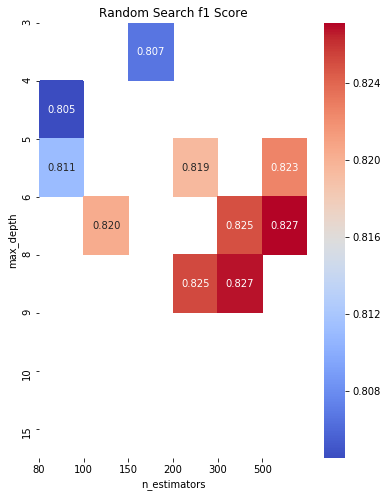

In [51]:
import seaborn as sns
print("Best HyperParameter: ",rsc.best_params_)
#print(GSC.best_score_)
#testscores = rsc.cv_results_['mean_test_score'].reshape(len(n_estimators),len(depth))

plt.figure(figsize=[len(n_estimators),len(depth)])
sns.heatmap(df_test, annot=True, cmap=plt.cm.coolwarm, fmt=".3f", xticklabels=n_estimators, yticklabels=depth)
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.xticks(np.arange(len(n_estimators)), n_estimators)
plt.yticks(np.arange(len(depth)), depth)
plt.title('Random Search f1 Score')
plt.show()

<b> Observation: </b>
1. RandomSearchCV is fasster than GridSearchCV as it randomly choses parameters to calculate instead of all possible points like GridSearchCV

In [121]:
optimal_model = XGBClassifier(max_depth=9,n_estimators=235,random_state=15,objective ='binary:logistic',n_jobs=-1,learning_rate=0.1)
optimal_model.fit(df_final_train, Y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=9, min_child_weight=1, missing=None, n_estimators=235,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=15, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [122]:
prediction = optimal_model.predict_proba(df_final_test)

In [142]:
optimal_model.get_xgb_params

<bound method XGBModel.get_xgb_params of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=9, min_child_weight=1, missing=None, n_estimators=235,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=15, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)>

In [143]:
log_loss_xgb = log_loss(Y_test,prediction)
best_depth = 9
best_n_estimators = 235
print(log_loss_xgb)

0.3426542846162706


In [144]:
print("Train log loss:", log_loss(Y_train,optimal_model.predict_proba(df_final_train))) 
print("Test log loss:",log_loss(Y_test,prediction))

Train log loss: 0.10475364433671278
Test log loss: 0.3426542846162706


<b> Observation: </b>
1. The low difference between Train Log loss and Test Log loss concludes that our model is not overfit

Total number of data points : 30000


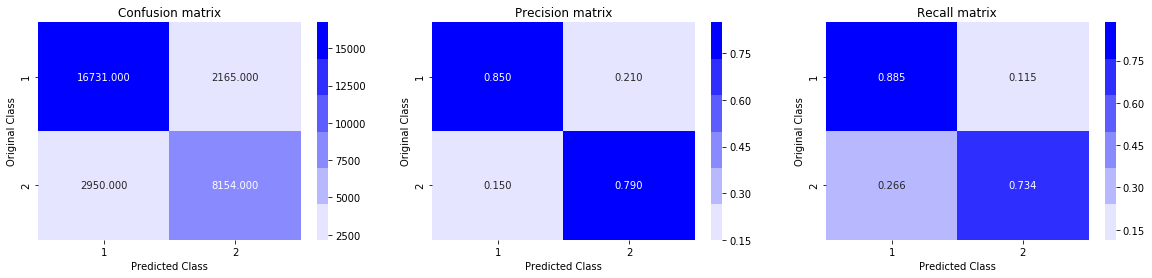

In [145]:
predicted_y =np.argmax(prediction>0.5,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(Y_test, predicted_y)

###### <b> Observation: </b>
1. 85% of points predicted as "is duplicate" are correctly classified
2. 79% of points predicted as "not duplicate" are correctly classified

<h1> 5. Conclusion </h1>

In [147]:
from prettytable import PrettyTable
comparison = PrettyTable()
comparison.field_names = ["Model","Vectorizer","alpha", "Depth", "No. of base learners", "Log Loss"]
comparison.add_row(["Logistic Regression","TFIDF W2V", best_alpha_LR, "-" , "-" ,log_loss_LR])
comparison.add_row(["SVM","TFIDF W2V", best_alpha_svm, "-" , "-", log_loss_svm])
comparison.add_row(["XGBoost","TFIDF W2V", "-", best_depth, best_n_estimators, log_loss_xgb])

print(comparison)


+---------------------+------------+-------+-------+----------------------+---------------------+
|        Model        | Vectorizer | alpha | Depth | No. of base learners |       Log Loss      |
+---------------------+------------+-------+-------+----------------------+---------------------+
| Logistic Regression | TFIDF W2V  |   2   |   -   |          -           | 0.49377039600644523 |
|         SVM         | TFIDF W2V  |   2   |   -   |          -           | 0.46165431636051774 |
|       XGBoost       | TFIDF W2V  |   -   |   9   |         235          |  0.3426542846162706 |
+---------------------+------------+-------+-------+----------------------+---------------------+


<b> Conclusion: </b>
1. With reference to the Comparison Report above, XGBoost performs well with log loss of 0.34. Which is much better than the Random Model(worst case) with log loss of 0.88 

<b> Steps followed to solve this problem: </b>
1. Understandng Business Problem and Converting it into Machine Learning Problem.
2. Understanding the data. Performing EDA. Chosing the right Metric for the problem.
3. Feature Engineering. As this is a text data. looking up various possible feature engineering ways.
3. Cleaning the data, preprocessing it such that its ready for ML Models.
4. Getting the worst case scenario result to have a comparison point.
5. Comparing Different Models' performance  and choosing the best one.
6. Making sure there are no errors like overfit/underfit or data leakage etc. in the complete solution.
   